## Library Imports

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import logging
import tensorflow as tf
from tqdm import tqdm
from datetime import datetime
from scipy.stats import skew, kurtosis
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

# Pre-processing of files 

In [35]:
def load_emothaw_data(directory_path):
    all_data = []
    all_labels = []

    # Use glob to find all .svc files in the specified directory
    file_paths = glob.glob(os.path.join(directory_path, "*.svc"))
    if not file_paths:
        # Raise an error if no files are found
        raise ValueError("No files found in the specified directory")

    # Iterate over each file path found
    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        try:
            # Extract the label from the filename
            # Assuming the label is the part before the first underscore '_'
            label = int(os.path.basename(file_path).split('_')[0])

            # Load the file and strip trailing spaces
            with open(file_path, 'r') as f:
                lines = [line.strip() for line in f.readlines() if line.strip()]  # Ignore empty lines

            # Convert the lines into a DataFrame by splitting each line by whitespace
            df = pd.DataFrame([line.split() for line in lines])  # Split by whitespace

            # Skip empty files
            if df.empty:
                print(f"Warning: {file_path} is empty after processing. Skipping file.")
                continue

            # First row contains the total number of data rows (excluding the first row)
            total_rows = int(df.iloc[0, 0])  # Number of expected sequences

            # Extract the feature data from the subsequent rows
            data = df.iloc[1:, :].values  # All columns are treated as features

            # Check if enough data rows exist as per the first row's instruction
            if data.shape[0] < total_rows:
                raise ValueError(f"Insufficient data: expected {total_rows}, but found {data.shape[0]}")

            # Ensure each row has exactly 7 feature values
            reshaped_data = []
            for row in data:
                if len(row) == 7:
                    reshaped_data.append(row)
                else:
                    print(f"Warning: Row does not have 7 values, skipping: {row}")

            # If valid reshaped data exists, convert it into a NumPy array
            if reshaped_data:
                reshaped_data = np.array(reshaped_data, dtype=float)  # Convert to float type

                # Check that reshaped data has enough rows as expected
                if reshaped_data.shape[0] < total_rows:
                    raise ValueError(f"Insufficient data: expected {total_rows}, but found {reshaped_data.shape[0]}")

                # Append the reshaped data and labels
                all_data.append(reshaped_data)
                all_labels.append([label] * reshaped_data.shape[0])  # Append the label for each data row

                # Print the shape of reshaped data for debugging
                print(f"Shape of data from file {file_path}: {reshaped_data.shape}")

        except Exception as e:
            # If any error occurs, display the error and continue processing the next file
            print(f"Error processing file {file_path}: {e}")
            continue

    # Raise an error if no valid data was processed
    if not all_data or not all_labels:
        raise ValueError("No valid data found in the directory")

    # Print the shapes of individual data entries for debugging
    print("Shapes of all_data before concatenation:")
    for i, data_array in enumerate(all_data):
        print(f"Data array {i} shape: {data_array.shape}")

    # Concatenate all data arrays along the sample axis (rows)
    try:
        all_data = np.concatenate(all_data, axis=0)  # Concatenate data arrays
    except Exception as e:
        print(f"Error during concatenation: {e}")

    # Concatenate labels
    all_labels = np.concatenate(all_labels, axis=0)

    # Return the processed data and corresponding labels
    return all_data, all_labels

# Importing all files on the Directory
data, labels = load_emothaw_data(r'./input_files/')  # Directory path


Processing file: ./input_files\0_hw00001.svc
Shape of data from file ./input_files\0_hw00001.svc: (2643, 7)
Processing file: ./input_files\1_hw00001.svc
Shape of data from file ./input_files\1_hw00001.svc: (2560, 7)
Processing file: ./input_files\2_hw00003.svc
Shape of data from file ./input_files\2_hw00003.svc: (3102, 7)
Processing file: ./input_files\3_hw00002.svc
Shape of data from file ./input_files\3_hw00002.svc: (5639, 7)
Shapes of all_data before concatenation:
Data array 0 shape: (2643, 7)
Data array 1 shape: (2560, 7)
Data array 2 shape: (3102, 7)
Data array 3 shape: (5639, 7)


In [36]:
for i in labels:
    print(i)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [37]:
print(len(labels))

13944


## FEATURE EXTRACTION

In [38]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Function to extract time-domain features with progress bar and logging
def extract_time_domain_features(data):
    logger.info("Starting time-domain feature extraction")
    start_time = datetime.now()

    time_features = []
    
    # Use tqdm to create a progress bar
    for sample in tqdm(data, desc="Extracting features", unit="sample"):
        sample_features = []
        for feature in sample.T:  # Assuming the features are along the last axis
            feature_stats = [
                np.mean(feature),
                np.std(feature),
                np.min(feature),
                np.max(feature),
                np.percentile(feature, 25),
                np.percentile(feature, 50),
                np.percentile(feature, 75),
            ]
            sample_features.extend(feature_stats)  # Append the computed stats to sample_features
        time_features.append(sample_features)  # Append the features for the sample

    end_time = datetime.now()
    elapsed_time = end_time - start_time
    logger.info(f"Feature extraction completed in {elapsed_time}")

    return np.array(time_features)

# Assuming 'data' is your input 3D array (samples, sequence length, features)
time_domain_features = extract_time_domain_features(data)



2024-10-23 18:54:03,938 - Starting time-domain feature extraction
Extracting features: 100%|██████████| 13944/13944 [02:05<00:00, 111.35sample/s]
2024-10-23 18:56:09,167 - Feature extraction completed in 0:02:05.226240


In [39]:
# Extracting frequency domain features using FFT with progress bar and logging
def extract_frequency_domain_features(data):
    logger.info("Starting frequency-domain feature extraction")
    start_time = datetime.now()
    
    freq_features = []
    
    # Ensure the data has the correct dimensions
    if len(data.shape) != 2:
        raise ValueError(f"Expected data with 2 dimensions (samples, features), but got {data.shape}")
    
    # Use tqdm to create a progress bar
    for sample in tqdm(data, desc="Extracting frequency features", unit="sample"):
        sample_features = []
        
        # Check if the sample is a 1D array
        if len(sample.shape) != 1:
            raise ValueError(f"Expected each sample to be 1D, but got {sample.shape}")

        # Apply FFT to the sample (which is already 1D, hence no need for .T)
        freq_feature = np.fft.fft(sample)
        freq_magnitude = np.abs(freq_feature)
        dominant_freq = np.argmax(freq_magnitude)
        freq_energy = np.sum(freq_magnitude)
        
        sample_features.extend([dominant_freq, freq_energy])
        freq_features.append(sample_features)
    
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    logger.info(f"Frequency-domain feature extraction completed in {elapsed_time}")

    return np.array(freq_features)

# Example usage: Assuming `data` is a 2D array (samples, features)
# data = np.random.rand(100, 50)  # Example data
frequency_domain_features = extract_frequency_domain_features(data)

# Log the output
logger.info(f"Data: {data}")
logger.info(f"Frequency Domain Features: {frequency_domain_features}")


2024-10-23 18:56:09,332 - Starting frequency-domain feature extraction
Extracting frequency features: 100%|██████████| 13944/13944 [00:00<00:00, 15547.57sample/s]
2024-10-23 18:56:10,238 - Frequency-domain feature extraction completed in 0:00:00.899867
2024-10-23 18:56:10,277 - Data: [[4.821600e+04 3.369600e+04 2.192338e+06 ... 1.870000e+03 4.800000e+02
  1.280000e+02]
 [4.819900e+04 3.370500e+04 2.192345e+06 ... 1.870000e+03 4.800000e+02
  2.490000e+02]
 [4.819900e+04 3.370800e+04 2.192353e+06 ... 1.870000e+03 4.900000e+02
  3.150000e+02]
 ...
 [4.505200e+04 1.201700e+04 1.771690e+06 ... 1.730000e+03 5.600000e+02
  2.480000e+02]
 [4.505200e+04 1.201700e+04 1.771698e+06 ... 1.730000e+03 5.600000e+02
  1.820000e+02]
 [4.505200e+04 1.201700e+04 1.771705e+06 ... 1.730000e+03 5.600000e+02
  8.800000e+01]]
2024-10-23 18:56:10,282 - Frequency Domain Features: [[       0.         15348978.31224078]
 [       0.         15349026.54532406]
 [       0.         15349082.72993092]
 ...
 [       0. 

In [40]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger()

# Function to extract statistical features with progress bar and logging
def extract_statistical_features(data):
    logger.info("Starting statistical feature extraction")
    start_time = datetime.now()
    
    statistical_features = []
    
    for sample in tqdm(data, desc="Extracting statistical features", unit="sample"):
        sample_features = []
        skew_value = skew(sample.T)
        kurtosis_value = kurtosis(sample.T)
        for feature in sample.T:
            mean = np.mean(feature)
            median = np.median(feature)
            variance = np.var(feature)
            feature_stats = [mean, median, variance, skew_value, kurtosis_value]
            sample_features.extend(feature_stats)
        statistical_features.append(sample_features)
    
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    logger.info(f"Statistical feature extraction completed in {elapsed_time}")
    
    return np.array(statistical_features)

# Example usage: Assuming 'data' is a 3D array (samples, sequence length, features)
statistical_features = extract_statistical_features(data)

# Log the output
logger.info(f"Data: {data}")
logger.info(f"Statistical Features: {statistical_features}")

2024-10-23 18:56:10,323 - Starting statistical feature extraction
Extracting statistical features: 100%|██████████| 13944/13944 [01:24<00:00, 165.15sample/s]
2024-10-23 18:57:34,791 - Statistical feature extraction completed in 0:01:24.465764
2024-10-23 18:57:34,891 - Data: [[4.821600e+04 3.369600e+04 2.192338e+06 ... 1.870000e+03 4.800000e+02
  1.280000e+02]
 [4.819900e+04 3.370500e+04 2.192345e+06 ... 1.870000e+03 4.800000e+02
  2.490000e+02]
 [4.819900e+04 3.370800e+04 2.192353e+06 ... 1.870000e+03 4.900000e+02
  3.150000e+02]
 ...
 [4.505200e+04 1.201700e+04 1.771690e+06 ... 1.730000e+03 5.600000e+02
  2.480000e+02]
 [4.505200e+04 1.201700e+04 1.771698e+06 ... 1.730000e+03 5.600000e+02
  1.820000e+02]
 [4.505200e+04 1.201700e+04 1.771705e+06 ... 1.730000e+03 5.600000e+02
  8.800000e+01]]
2024-10-23 18:57:34,918 - Statistical Features: [[4.82160000e+04 4.82160000e+04 0.00000000e+00 ... 0.00000000e+00
  2.03885544e+00 2.16142644e+00]
 [4.81990000e+04 4.81990000e+04 0.00000000e+00 ...

In [41]:
print("Time Domain Features")
print(time_domain_features)
print("Frequency")
print(frequency_domain_features)
print("Statistical Features")
print(statistical_features)
print(time_domain_features.shape)
print(frequency_domain_features.shape)
print(statistical_features.shape)

Time Domain Features
[[48216.     0. 48216. ...   128.   128.   128.]
 [48199.     0. 48199. ...   249.   249.   249.]
 [48199.     0. 48199. ...   315.   315.   315.]
 ...
 [45052.     0. 45052. ...   248.   248.   248.]
 [45052.     0. 45052. ...   182.   182.   182.]
 [45052.     0. 45052. ...    88.    88.    88.]]
Frequency
[[       0.         15348978.31224078]
 [       0.         15349026.54532406]
 [       0.         15349082.72993092]
 ...
 [       0.         12403825.1422149 ]
 [       0.         12403881.09007366]
 [       0.         12403930.03576907]]
Statistical Features
[[4.82160000e+04 4.82160000e+04 0.00000000e+00 ... 0.00000000e+00
  2.03885544e+00 2.16142644e+00]
 [4.81990000e+04 4.81990000e+04 0.00000000e+00 ... 0.00000000e+00
  2.03885976e+00 2.16143599e+00]
 [4.81990000e+04 4.81990000e+04 0.00000000e+00 ... 0.00000000e+00
  2.03886182e+00 2.16144052e+00]
 ...
 [4.50520000e+04 4.50520000e+04 0.00000000e+00 ... 0.00000000e+00
  2.03871355e+00 2.16107160e+00]
 [4.505

In [21]:
## MultiHeadSelf Attention Layer

In [22]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim  # Total embedding dimension
        self.num_heads = num_heads  # Number of attention heads
        
        # Ensure that the embedding dimension is divisible by the number of heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        
        # Calculate the dimension per head
        self.projection_dim = embed_dim // num_heads
        
        # Dense layers for query, key, and value projections
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        
        # Dense layer to combine the heads' outputs
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        # Calculate the attention scores
        score = tf.matmul(query, key, transpose_b=True)
        
        # Scale the scores by the square root of the key dimension
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        
        # Apply softmax to get the attention weights
        weights = tf.nn.softmax(scaled_score, axis=-1)
        
        # Compute the output as a weighted sum of the values
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        # Reshape the input tensor to separate the heads
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])  # Transpose for compatibility with attention computation

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]  # Get the batch size
        
        # Apply dense layers to inputs to create query, key, and value tensors
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        # Separate the heads for query, key, and value tensors
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        
        # Calculate the attention output and weights
        attention, weights = self.attention(query, key, value)
        
        # Transpose the attention output back to the original shape
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        # Combine the heads' outputs
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)  # Final dense layer to project the output
        return output


## Transformer Block

In [23]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        
        # Initialize the multi-head self-attention layer
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        
        # Feedforward network: A sequential model with a ReLU activation function
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        
        # Layer normalization for residual connections
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        # Dropout layers for regularization
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        # Apply multi-head self-attention to the input
        attn_output = self.att(inputs)
        
        # Apply dropout to the attention output (only during training)
        attn_output = self.dropout1(attn_output, training=training)
        
        # Add the original input (residual connection) to the attention output and apply layer normalization
        out1 = self.layernorm1(inputs + attn_output)
        
        # Pass through the feedforward network
        ffn_output = self.ffn(out1)
        
        # Apply dropout to the feedforward output (only during training)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Add the output from the feedforward network to the previous output (residual connection) and apply layer normalization
        return self.layernorm2(out1 + ffn_output)


Transformer Classifier

In [24]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model

class TransformerClassifier(Model):
    def __init__(self, num_classes, embed_dim, num_heads, ff_dim, num_layers):
        super(TransformerClassifier, self).__init__()
        
        # Dense layer to project input features into the embedding dimension
        self.dense_input = layers.Dense(embed_dim)
        
        # Create multiple transformer blocks as specified by num_layers
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        
        # Global average pooling layer to reduce dimensionality before classification
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        
        # Final dense layer for classification with softmax activation
        self.dense = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):  # Include training parameter
        # Project inputs to the embedding dimension
        x = self.dense_input(inputs)
        
        # Pass the projected inputs through each transformer block
        for transformer in self.transformer_blocks:
            x = transformer(x, training=training)  # Forward the training parameter to transformer blocks
            
        # Apply global average pooling to reduce dimensionality
        x = self.global_average_pooling(x)
        
        # Pass the pooled output through the final dense layer
        return self.dense(x)

# Splitting the data into training and testing sets
features = np.concatenate((time_domain_features, frequency_domain_features, statistical_features), axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Defining the model parameters
num_classes = 4  # Number of output classes for classification
embed_dim = 128  # Embedding dimension for the transformer
num_heads = 4    # Number of attention heads in each transformer block
ff_dim = 128     # Dimension of the feedforward network
num_layers = 2   # Number of transformer blocks in the model

# Creating the Transformer model
model = TransformerClassifier(num_classes, embed_dim, num_heads, ff_dim, num_layers)

# Compiling the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(optimizer=Adam(clipnorm=1.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model on the training data
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)
directory = './newmodels/'
model_path = os.path.join(directory, 'newworkinghigh.model.keras')

model.save(model_path)
# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9400 - loss: 0.1686 - val_accuracy: 1.0000 - val_loss: 2.4313e-06
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 185ms/step - accuracy: 1.0000 - loss: 4.1138e-06 - val_accuracy: 1.0000 - val_loss: 9.0373e-07
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 1.0000 - loss: 1.8662e-06 - val_accuracy: 1.0000 - val_loss: 5.2937e-07
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 1.0000 - loss: 1.2483e-06 - val_accuracy: 1.0000 - val_loss: 4.2158e-07
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - accuracy: 1.0000 - loss: 9.7129e-07 - val_accuracy: 1.0000 - val_loss: 3.8214e-07
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 1.0000 - loss: 4.0257e-07
Test Loss: 3.9943927276908653e-07, Test Accuracy: 1.0


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


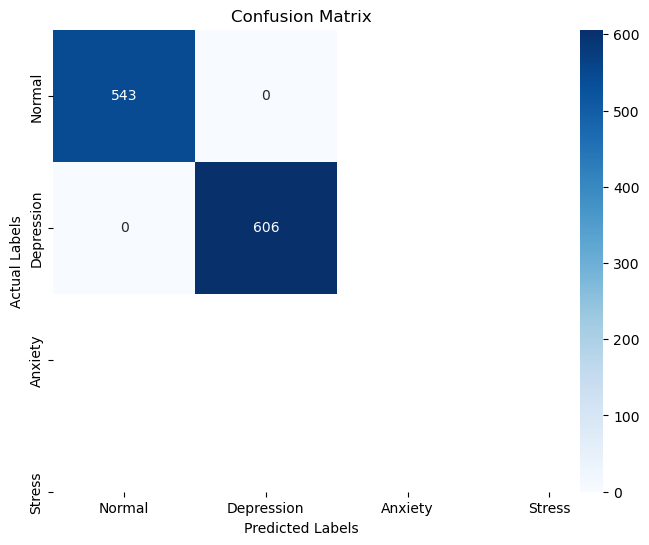

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred_probs = model.predict(X_test)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Step 2: Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = ['Normal','Depression', 'Anxiety', 'Stress']
# Step 3: Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()


In [26]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Print classification report with improved formatting
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)

# Convert classification report to a table
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
rows = [[cls, 
         f"{metrics['precision']:.2f}", 
         f"{metrics['recall']:.2f}", 
         f"{metrics['f1-score']:.2f}", 
         int(metrics['support'])] for cls, metrics in report.items() if cls != 'accuracy']

# Add accuracy row separately
accuracy_row = ["Accuracy", "-", "-", f"{accuracy_score(y_test, y_pred) * 100:.2f}%", "-"]
rows.append(accuracy_row)

# Print the table
print(tabulate(rows, headers, tablefmt="fancy_grid"))

# Compute and display individual scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display overall metrics in a formatted style
print("\nOverall Metrics:")
overall_metrics = [
    ["Metric", "Score"],
    ["Accuracy", f"{accuracy * 100:.2f}%"],
    ["Precision (weighted)", f"{precision:.2f}"],
    ["Recall (weighted)", f"{recall:.2f}"],
    ["F1-Score (weighted)", f"{f1:.2f}"]
]

print(tabulate(overall_metrics, headers="firstrow", tablefmt="fancy_grid"))


Classification Report:


ValueError: Number of classes, 2, does not match size of target_names, 4. Try specifying the labels parameter

# END
